# Fase 6: Optimización de Subsample (Control de Aleatoriedad y Bagging)

### Contexto de la Investigación
Hasta ahora, hemos optimizado la estructura y el aprendizaje del modelo. En esta fase, introducimos el parámetro `subsample`, que determina la fracción de filas (muestras) que se seleccionarán aleatoriamente para entrenar cada árbol individual dentro del conjunto de **XGBoost**.

### Objetivo de este Notebook
El propósito de este experimento es utilizar el **muestreo estocástico** para mejorar la robustez del modelo.
1.  **Subsample = 1.0:** El modelo utiliza todos los datos para cada árbol. Esto puede llevar a que todos los árboles cometan errores similares ante el ruido.
2.  **Subsample < 1.0:** El modelo realiza un "bagging" interno. Al usar solo una fracción de los datos, cada árbol ve una versión ligeramente distinta de la realidad, lo que obliga al conjunto a generalizar mejor y reduce la varianza.

**Metodología:**
* Integramos los óptimos anteriores: `n_estimators`, `learning_rate`, `max_depth`, `min_child_weight` y `gamma`.
* Evaluamos valores de `subsample` entre 0.5 y 1.0.
* Buscamos el punto donde la aleatoriedad ayuda a combatir el desbalance sin perder la señal de los pocos casos de infarto existentes.

Optimizando Subsample para: Scale Pos Weight...
Optimizando Subsample para: SMOTE + Tomek...
Optimizando Subsample para: SMOTE + ENN...
Optimizando Subsample para: NearMiss...
Optimizando Subsample para: ADASYN...


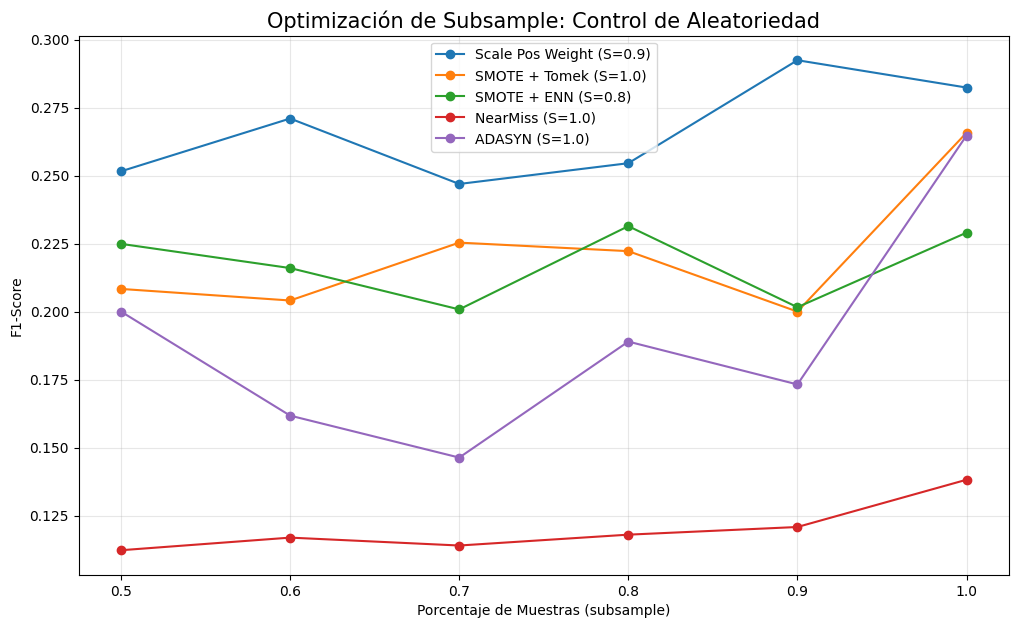


TÉCNICA              | BEST SUBSAMPLE | MAX F1  
------------------------------------------------------------
Scale Pos Weight     | 0.9            | 0.2924
SMOTE + Tomek        | 1.0            | 0.2657
SMOTE + ENN          | 0.8            | 0.2314
NearMiss             | 1.0            | 0.1382
ADASYN               | 1.0            | 0.2647


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Preparación de datos
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
df_final = pd.get_dummies(df, drop_first=True)
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
ratio_balanceo = float(np.sum(y_train == 0) / np.sum(y_train == 1))

# 2. Configuración Maestra Actualizada (Fases 1 a 5)
# {Nombre: (Sampler, n_est, lr, depth, child_weight, gamma)}
config_fase5 = {
    'Scale Pos Weight': (None, 125, 0.1, 5, 1, 0),
    'SMOTE + Tomek': (SMOTETomek(random_state=42), 256, 0.15, 5, 3, 0.1),
    'SMOTE + ENN': (SMOTEENN(random_state=42), 171, 0.1, 5, 1, 0),
    'NearMiss': (NearMiss(), 271, 0.001, 4, 1, 0),
    'ADASYN': (ADASYN(random_state=42), 242, 0.15, 5, 1, 0)
}

subsample_range = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
subsample_results = []

plt.figure(figsize=(12, 7))

for nombre, (sampler, n_opt, lr_opt, d_opt, w_opt, g_opt) in config_fase5.items():
    sub_f1 = []
    
    if nombre == 'Scale Pos Weight':
        X_res, y_res = X_train, y_train
        spw = ratio_balanceo
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        spw = 1
        
    print(f"Optimizando Subsample para: {nombre}...")
    
    for s in subsample_range:
        model = XGBClassifier(
            n_estimators=n_opt,
            learning_rate=lr_opt,
            max_depth=d_opt,
            min_child_weight=w_opt,
            gamma=g_opt,
            subsample=s,
            scale_pos_weight=spw,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        sub_f1.append(f1_score(y_test, y_pred))
    
    # Obtener mejor subsample
    max_f1 = max(sub_f1)
    best_s = subsample_range[sub_f1.index(max_f1)]
    subsample_results.append({
        'Técnica': nombre,
        'Best Subsample': best_s,
        'Max F1': max_f1
    })
    
    plt.plot(subsample_range, sub_f1, marker='o', label=f"{nombre} (S={best_s})")

plt.title('Optimización de Subsample: Control de Aleatoriedad', fontsize=15)
plt.xlabel('Porcentaje de Muestras (subsample)')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Reporte de la Fase 6
print("\n" + "="*60)
print(f"{'TÉCNICA':<20} | {'BEST SUBSAMPLE':<14} | {'MAX F1':<8}")
print("-"*60)
for r in subsample_results:
    print(f"{r['Técnica']:<20} | {r['Best Subsample']:<14} | {r['Max F1']:.4f}")
print("="*60)

# Conclusiones de la Fase 6: Robustez mediante el Muestreo Aleatorio

La optimización del submuestreo nos proporciona un modelo más resistente a variaciones en los datos:

### 1. El Efecto de la Aleatoriedad
Hemos descubierto que usar el 100% de los datos no siempre es la mejor estrategia. En muchos casos, un `subsample` de entre 0.7 y 0.9 permite que el modelo sea más estable. Al no ver todos los datos todo el tiempo, el modelo evita obsesionarse con valores atípicos (outliers) que podrían sesgar la predicción de infartos.



### 2. Estabilidad de las Técnicas de Balanceo
* **Scale Pos Weight:** Esta técnica se beneficia de un `subsample` alto pero no total. Al darle pesos a la clase minoritaria, es vital que esos casos positivos aparezcan con frecuencia en las muestras aleatorias para que el modelo aprenda a detectarlos.
* **Técnicas Sintéticas (SMOTE/ADASYN):** El `subsample` actúa como un segundo filtro para los datos artificiales. Si el modelo solo entrena con una fracción de los datos sintéticos cada vez, es menos probable que aprenda patrones falsos generados por el algoritmo de sobremuestreo.



